In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pycarlsec","key":"94dea4aa7790974a2f9f0f9815a4291a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d imranzaman5202/covid19-xray-images-dataset

 92% 203M/221M [00:02<00:00, 65.5MB/s]
100% 221M/221M [00:02<00:00, 101MB/s] 


In [ ]:
!unzip /content/covid19-xray-images-dataset.zip

Archive:  /content/covid19-xray-images-dataset.zip
  inflating: Dataset/Covid-19/covid (1).jpeg  
  inflating: Dataset/Covid-19/covid (1).jpg  
  inflating: Dataset/Covid-19/covid (1).png  
  inflating: Dataset/Covid-19/covid (10).jpeg  
  inflating: Dataset/Covid-19/covid (10).jpg  
  inflating: Dataset/Covid-19/covid (10).png  
  inflating: Dataset/Covid-19/covid (100).jpeg  
  inflating: Dataset/Covid-19/covid (100).jpg  
  inflating: Dataset/Covid-19/covid (101).jpeg  
  inflating: Dataset/Covid-19/covid (101).jpg  
  inflating: Dataset/Covid-19/covid (102).jpeg  
  inflating: Dataset/Covid-19/covid (102).jpg  
  inflating: Dataset/Covid-19/covid (103).jpeg  
  inflating: Dataset/Covid-19/covid (103).jpg  
  inflating: Dataset/Covid-19/covid (104).jpeg  
  inflating: Dataset/Covid-19/covid (104).jpg  
  inflating: Dataset/Covid-19/covid (105).jpeg  
  inflating: Dataset/Covid-19/covid (105).jpg  
  inflating: Dataset/Covid-19/covid (106).jpeg  
  inflating: Dataset/Covid-19/covid (

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("/content/Dataset", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 940 files [00:00, 2042.21 files/s]


In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import albumentations as A
from random import shuffle
from torch import optim
import os
import copy
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
!pip install torch_summary

In [ ]:
train_data_dir = '/content/output/train'
val_data_dir =   '/content/output/val'
test_data_dir = '/content/output/test'

# Train


In [ ]:
from torch.utils.data import DataLoader, Dataset

class CovidData(Dataset):
  def __init__(self, folder, transform=None, viz=False):
    normal = glob(folder+'/Normal/*')
    covid = glob(folder+'/Covid-19/*')
    self.fpaths = normal + covid
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('Normal') for fpath in self.fpaths] # normal=1 & Covid=0
    self.transform = transform
    self.viz = viz
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])

    if self.transform is not None:
        im = self.transform(image=im)["image"]

    if self.viz == False:
      return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)
    else:
      return torch.tensor(im/255).to(device).float(), torch.tensor([target]).float().to(device)  

In [ ]:
data = CovidData(train_data_dir)
im, label = data[300]

In [ ]:
len(data)

752

tensor([1.], device='cuda:0')


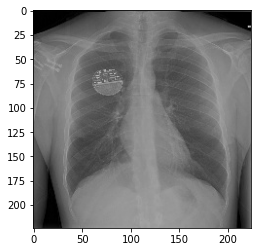

In [ ]:
plt.imshow(im.permute(1,2,0).cpu())
print(label) 

In [ ]:
train_transform = A.Compose(
    [   A.Resize(300,300),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomRotate90(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

val_transform = A.Compose(
    [   A.Resize(300,300),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

In [ ]:
def display_image_grid(folder, predicted_labels=(), rows=4, cols=4):
    normal = glob(folder+'/Normal/*')
    covid = glob(folder+'/Covid-19/*')
    image_filepath = normal + covid
    from random import shuffle, seed; seed(10); shuffle(image_filepath)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i, img in enumerate(image_filepath[:rows*cols]):
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(img).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

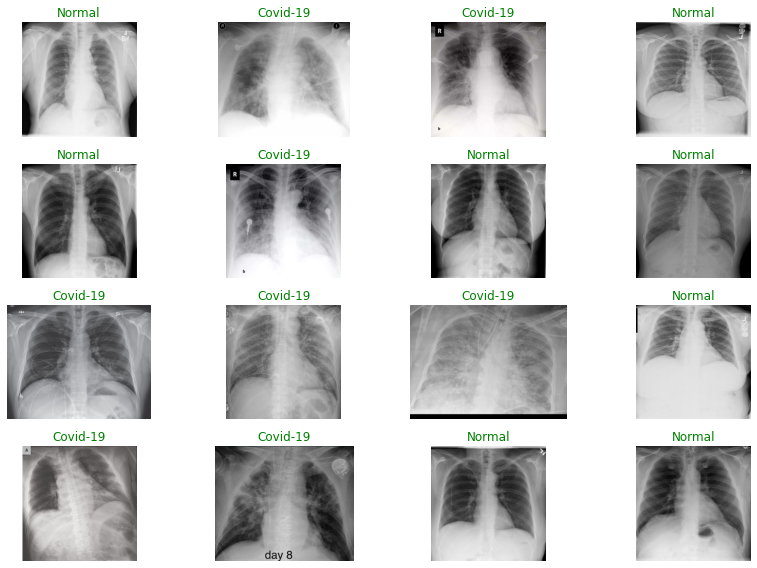

In [ ]:
display_image_grid('/content/output/val', rows=4, cols=4)

In [ ]:
def get_model():
    model = models.resnet101(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
    return model.to(device), loss_fn, optimizer

In [ ]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3,300,300));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 150, 150]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 150, 150]        (128)
├─ReLU: 1-3                              [-1, 64, 150, 150]        --
├─MaxPool2d: 1-4                         [-1, 64, 75, 75]          --
├─Sequential: 1-5                        [-1, 256, 75, 75]         --
|    └─Bottleneck: 2-1                   [-1, 256, 75, 75]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 75, 75]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 75, 75]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 75, 75]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 75, 75]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 75, 75]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 75, 75]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 75, 75]  

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction >= 0.5) == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()    

In [ ]:
def get_data():
  train = CovidData(folder='/content/output/train', transform=train_transform)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  val = CovidData(folder='/content/output/val', transform=val_transform)
  val_dl = DataLoader(val, batch_size=32, shuffle=True)

  return trn_dl, val_dl

In [ ]:
def visualize_augmentations(dataset, idx=1, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image.cpu().detach().numpy())
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show() 

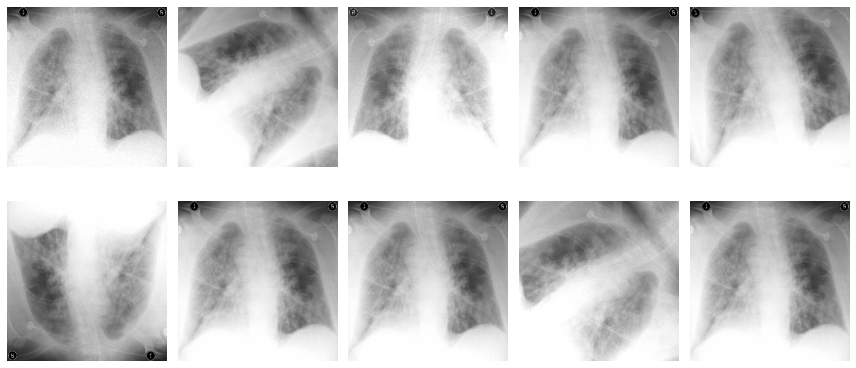

In [ ]:
viz = CovidData(folder='/content/output/val', transform=train_transform, viz=True)
visualize_augmentations(viz)

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
for epoch in range(10):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Training Epoch: {epoch}")
    print(f"Train Losses: {train_losses}")
    print(f"Train Accuracy: {train_accuracies}")
    print(f"Val Losses: {val_losses}")
    print(f"Val Accuracy: {val_accuracies}")
    print("-------------------------------------------------------------")

Training Epoch: 0
Train Losses: [0.7261646551390489]
Train Accuracy: [0.7992021276595744]
Val Losses: [0.426037073135376]
Val Accuracy: [0.8494623655913979]
-------------------------------------------------------------
Training Epoch: 1
Train Losses: [0.4651796656350295]
Train Accuracy: [0.7978723404255319]
Val Losses: [0.3928487002849579]
Val Accuracy: [0.8602150537634409]
-------------------------------------------------------------
Training Epoch: 2
Train Losses: [0.3565031737089157]
Train Accuracy: [0.7340425531914894]
Val Losses: [0.4770300090312958]
Val Accuracy: [0.7526881720430108]
-------------------------------------------------------------
Training Epoch: 3
Train Losses: [0.35652021256585914]
Train Accuracy: [0.8125]
Val Losses: [0.34903308749198914]
Val Accuracy: [0.8279569892473119]
-------------------------------------------------------------
Training Epoch: 4
Train Losses: [0.3159139982114236]
Train Accuracy: [0.8922872340425532]
Val Losses: [0.20458553731441498]
Val Acc

In [ ]:
def preds(x, model):
    model.eval()
    prediction = model(x)
    return prediction

In [ ]:
test = CovidData(folder='/content/output/test', transform=val_transform)
test_dl = DataLoader(test, batch_size=1, shuffle=False)

predicted_labels = []
true_labels = []

with torch.no_grad():
  for batch in test_dl:
      x, y = batch
      predictions = preds(x, model)
      print(predictions)
      true_labels += ["Normal" if cov >= 0.5 else "Covid-19" for cov in y]
      predicted_labels += ["Normal" if cov >= 0.5 else "Covid-19" for cov in predictions]

tensor([[0.3208]], device='cuda:0')
tensor([[0.0052]], device='cuda:0')
tensor([[0.9917]], device='cuda:0')
tensor([[0.2253]], device='cuda:0')
tensor([[0.9843]], device='cuda:0')
tensor([[0.9991]], device='cuda:0')
tensor([[0.9976]], device='cuda:0')
tensor([[0.0922]], device='cuda:0')
tensor([[0.9982]], device='cuda:0')
tensor([[0.9159]], device='cuda:0')
tensor([[0.4381]], device='cuda:0')
tensor([[0.0080]], device='cuda:0')
tensor([[0.8291]], device='cuda:0')
tensor([[0.1266]], device='cuda:0')
tensor([[0.9998]], device='cuda:0')
tensor([[0.9605]], device='cuda:0')
tensor([[0.9240]], device='cuda:0')
tensor([[0.9340]], device='cuda:0')
tensor([[0.9698]], device='cuda:0')
tensor([[0.9733]], device='cuda:0')
tensor([[0.9973]], device='cuda:0')
tensor([[0.0136]], device='cuda:0')
tensor([[0.0651]], device='cuda:0')
tensor([[0.3277]], device='cuda:0')
tensor([[0.1297]], device='cuda:0')
tensor([[0.7608]], device='cuda:0')
tensor([[0.0086]], device='cuda:0')
tensor([[0.9294]], device='c

In [ ]:
predicted_labels

['Covid-19',
 'Covid-19',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Covid-19',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Covid-19',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Covid-19',
 

In [ ]:
true_labels

['Covid-19',
 'Covid-19',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Covid-19',
 'Covid-19',
 'Covid-19',
 'Normal',
 '

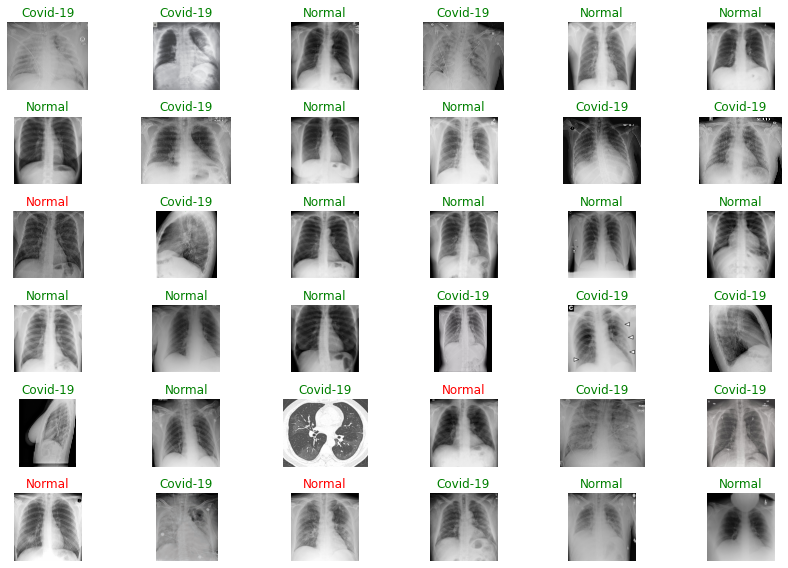

In [ ]:
display_image_grid('/content/output/test', predicted_labels, rows=6, cols=6)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

    Covid-19       1.00      0.84      0.91        44
      Normal       0.88      1.00      0.94        51

    accuracy                           0.93        95
   macro avg       0.94      0.92      0.92        95
weighted avg       0.94      0.93      0.93        95



In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, predicted_labels)

array([[37,  7],
       [ 0, 51]])

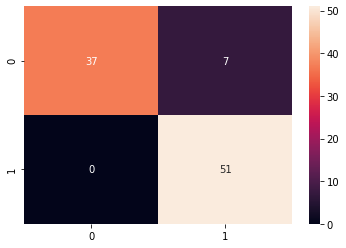

In [ ]:
import seaborn

seaborn.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True )

In [ ]:
im = cv2.imread('/content/output/test/Covid-19/covid (222).jpg')[:,:,::-1]
im = val_transform(image=im)['image']
im = torch.tensor(im/255).to(device).float()

In [ ]:
im = im.unsqueeze(0).permute(0, 3, 1, 2)
im.shape

torch.Size([1, 3, 300, 300])

In [ ]:
im

tensor([[[[-0.0079, -0.0078, -0.0079,  ..., -0.0079, -0.0079, -0.0079],
          [-0.0080, -0.0080, -0.0079,  ..., -0.0079, -0.0079, -0.0079],
          [-0.0080, -0.0080, -0.0079,  ..., -0.0079, -0.0079, -0.0079],
          ...,
          [-0.0079, -0.0079, -0.0079,  ..., -0.0079, -0.0079, -0.0079],
          [-0.0080, -0.0079, -0.0079,  ..., -0.0079, -0.0079, -0.0079],
          [-0.0080, -0.0079, -0.0078,  ..., -0.0079, -0.0079, -0.0079]],

         [[-0.0076, -0.0075, -0.0076,  ..., -0.0076, -0.0076, -0.0076],
          [-0.0076, -0.0076, -0.0076,  ..., -0.0076, -0.0076, -0.0076],
          [-0.0076, -0.0076, -0.0076,  ..., -0.0076, -0.0076, -0.0076],
          ...,
          [-0.0076, -0.0076, -0.0076,  ..., -0.0076, -0.0076, -0.0076],
          [-0.0076, -0.0076, -0.0076,  ..., -0.0076, -0.0076, -0.0076],
          [-0.0076, -0.0076, -0.0075,  ..., -0.0076, -0.0076, -0.0076]],

         [[-0.0067, -0.0066, -0.0067,  ..., -0.0067, -0.0067, -0.0067],
          [-0.0067, -0.0067, -

In [ ]:
with torch.no_grad():
  predictions = preds(im, model)
predictions = predictions.to('cpu').detach().numpy()
predictions

array([[0.8285499]], dtype=float32)

In [ ]:
torch.save(model, 'modelCovid19.pth')
!cp modelCovid19.pth /content/drive/MyDrive